In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
Data = pd.read_csv('fulldata.csv')

In [3]:

Data.info()
Data.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189488 entries, 0 to 189487
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   name    189488 non-null  object 
 1   energy  189488 non-null  float64
 2   diag    189488 non-null  float64
 3   pca1    189488 non-null  float64
 4   pca2    189488 non-null  float64
 5   pca3    189488 non-null  float64
dtypes: float64(5), object(1)
memory usage: 8.7+ MB


,count,mean,std,min,25%,50%,75%,max
energy,189488.0,23.224939,24.828596,0.280758,0.578519,35.489707,38.119598,99.991317
diag,189488.0,0.233942,0.251381,0.005000,0.005000,0.378000,0.378000,1.000000
pca1,189488.0,0.126102,0.193949,-0.878344,0.023608,0.057811,0.193317,0.996973
pca2,189488.0,0.053110,0.225161,-0.983825,-0.010437,0.022784,0.175336,0.979041
pca3,189488.0,-0.000552,0.231339,-0.960883,-0.062514,0.008743,0.097253,0.981669


In [4]:
null_counts = Data.isna().sum()
null_counts


name      0
energy    0
diag      0
pca1      0
pca2      0
pca3      0
dtype: int64

<AxesSubplot: >

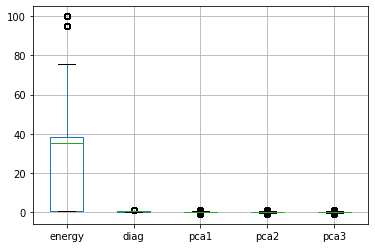

In [5]:
features = ['energy','diag','pca1', 'pca2', 'pca3']
Data.boxplot(features)

<AxesSubplot: >

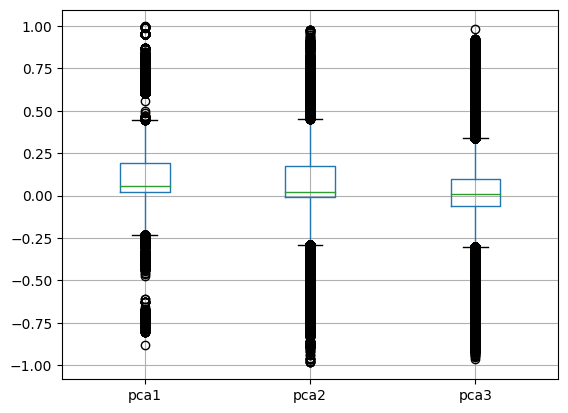

In [6]:
features = ['pca1', 'pca2', 'pca3']
Data.boxplot(features)

In [7]:
selected_features = ['diag','pca1','pca2','pca3']
X = Data[selected_features]

In [8]:
selected_features = ['diag','pca1','pca2','pca3']
X = Data[selected_features]

In [9]:
selected_features = ['diag','pca1','pca2','pca3','count','Bin']
Data['count'] = Data.groupby('name')['name'].transform('count')
bins = [0, 13, 20, float("inf")]
labels = ['0-13', '14-20', '20+']
Data['Bin'] = pd.cut(Data['count'], bins=bins, labels=labels)
X = Data[selected_features]
X['count'].value_counts()

20    18860
26    18512
16    17024
18    14022
17    13039
15    12870
24    10128
21     9471
34     9010
28     8792
22     8690
14     8330
13     8281
23     6624
12     5928
25     5175
40     4600
19     3914
11     2508
10     2180
9       783
8       624
7       119
4         4
Name: count, dtype: int64

In [10]:
target =  ['energy']
y = Data[target]

In [11]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
lgbm_model = LGBMRegressor(n_estimators=10000, learning_rate=0.035, num_leaves=91, min_child_samples=10)


In [12]:
mae_train_list = []
mae_test_list = []

In [13]:
for train_idx, test_idx in cv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = ['mae']

    lgbm_model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

    y_pred_train = lgbm_model.predict(X_train)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_train_list.append(mae_train)

    y_pred_test = lgbm_model.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mae_test_list.append(mae_test)

print(f"Mean absolute error on training set: {np.mean(mae_train_list):.3f} +/- {np.std(mae_train_list):.3f}")
print(f"Mean absolute error on testing set: {np.mean(mae_test_list):.3f} +/- {np.std(mae_test_list):.3f}")


C:\Users\gts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\gts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\gts\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages

Mean absolute error on training set: 0.009 +/- 0.000
Mean absolute error on testing set: 0.019 +/- 0.000


In [14]:
predicted_output_train = lgbm_model.predict(X_train)
actual_output_train = y_train.values.flatten()

In [15]:
df_train = pd.DataFrame({'Predicted Energy': predicted_output_train, 'Actual Energy': actual_output_train})
print(df_train.head(10))

   Predicted Energy  Actual Energy
0         38.148114      38.145186
1          0.571384       0.573634
2          0.590334       0.580474
3         37.975774      37.980501
4         75.368052      75.370940
5          0.584507       0.580111
6         38.152375      38.156990
7          0.571384       0.576936
8          0.575859       0.577169
9         75.362115      75.371735
